In [4]:
# Importar Librerias
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, auc,
    classification_report
)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")


In [5]:
# Cargar el dataset final
main_path="drive/MyDrive/Dataset_MP"
name= "df_final.csv"
full_path=os.path.join(main_path,name)

df = pd.read_csv(full_path)

In [6]:
# Crear muestra representativa, 500000 por temas de rendimiento
df_modelo, _ = train_test_split(df, train_size=500000, stratify=df['DELAYED'], random_state=42)

print("Tamaño de la muestra:", df_modelo.shape)
print("Proporción de clases:\n", df_modelo['DELAYED'].value_counts(normalize=True))

Tamaño de la muestra: (500000, 13)
Proporción de clases:
 DELAYED
0    0.81389
1    0.18611
Name: proportion, dtype: float64


In [7]:
# ENTRENAMIENTO
X = df_modelo.drop('DELAYED', axis=1)
y = df_modelo['DELAYED']

# Entrenamiento 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

colum_categorica = ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
colum_numeric= ['MONTH', 'DAY', 'DAY_OF_WEEK', 'DISTANCE',
                'SCHEDULED_DEPARTURE_sin', 'SCHEDULED_DEPARTURE_cos',
                'SCHEDULED_ARRIVAL_sin', 'SCHEDULED_ARRIVAL_cos', 'SCHEDULED_TIME']

In [8]:
# Column transform, usamos standarsscaler() para las numericas y onehotencoder() para las categoricas
def get_preprocessor(model_name):
    sparse = False if model_name == "Hist Gradient Boosting" else True
    return ColumnTransformer([
        ('num', StandardScaler(), colum_numeric),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=sparse), colum_categorica)
    ])

In [9]:
# Modelos con hiperparámetros básicos para GridSearch
modelos_param_grid = {
    "LightGBM": {
        "model": LGBMClassifier(random_state=42),
        "params": {
            'classifier__num_leaves': [31],
            'classifier__learning_rate': [0.1],
            'classifier__n_estimators': [100]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "params": {
            'classifier__max_depth': [6],
            'classifier__learning_rate': [0.1],
            'classifier__n_estimators': [100]
        }
    },
    "CatBoost": {
        "model": CatBoostClassifier(verbose=0, random_state=42),
        "params": {
            'classifier__depth': [6],
            'classifier__learning_rate': [0.1],
            'classifier__iterations': [100]
        }
    }
}


In [10]:
# Función para evaluar el modelo
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo):
    y_pred = modelo.predict(X_test)
    if hasattr(modelo, "predict_proba"):
        y_prob = modelo.predict_proba(X_test)[:, 1]
    elif hasattr(modelo, "decision_function"):
        y_prob = modelo.decision_function(X_test)
    else:
        y_prob = None

    print(f"\nEvaluación del modelo {nombre_modelo}:\n")
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
    print("Precision:", round(precision_score(y_test, y_pred), 3))
    print("Recall:", round(recall_score(y_test, y_pred), 3))
    print("F1 Score:", round(f1_score(y_test, y_pred), 3))

    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        print("\nAUC-ROC:", round(roc_auc, 3))

        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0,1], [0,1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Curva ROC - {nombre_modelo}')
        plt.legend(loc="lower right")
        plt.show()

    cm = confusion_matrix(y_test, y_pred)
    print('\nMatriz de confusión:')
    print(cm)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No", "Sí"], yticklabels=["No", "Sí"])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusión - {nombre_modelo}')
    plt.show()

    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred))


In [11]:
# Estrategias de balanceo
def run_modelos():
    resultados = []
    modelos_optimizados = {}

    for nombre, data in modelos_param_grid.items():
        print(f"\nMODELO: {nombre} ")
        preprocessor = get_preprocessor(nombre)

        #Sin balanceo
        print(f"\nEntrenando {nombre} sin balanceo")
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', data["model"])
        ])
        grid = GridSearchCV(pipeline, param_grid=data["params"], scoring='f1', cv=3, n_jobs=-1)
        grid.fit(X_train, y_train)
        evaluar_modelo(grid.best_estimator_, X_test, y_test, f"{nombre} (Sin balanceo)")
        resultados.append({
            'Modelo': nombre,
            'Balanceo': 'Sin balanceo',
            'F1 Score': grid.best_score_,
            'Best Params': grid.best_params_
        })
        modelos_optimizados[f"{nombre} (Sin balanceo)"] = grid.best_estimator_

        #Class Weight
        print(f"\nEntrenando {nombre} con class_weight")
        # Solo LightGBM y XGBoost soportan class_weight en parámetros
        if nombre == "LightGBM":
            model_cw = LGBMClassifier(random_state=42, class_weight='balanced')
            params_cw = data["params"]
        elif nombre == "XGBoost":
            model_cw = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())
            params_cw = data["params"]
        elif nombre == "CatBoost":
            # CatBoost usa 'class_weights' con lista, que tiene que ser pasada directamente y no con GridSearchCV sin pipeline
            # Aquí lo haremos fijo y sin GridSearch para simplicidad y velocidad
            class_weights = [1, (y_train == 0).sum() / (y_train == 1).sum()]
            model_cw = CatBoostClassifier(verbose=0, random_state=42, class_weights=class_weights)
            params_cw = None
        else:
            model_cw = data["model"]
            params_cw = data["params"]

        if nombre != "CatBoost":
            pipeline_cw = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', model_cw)
            ])
            grid_cw = GridSearchCV(pipeline_cw, param_grid=params_cw, scoring='f1', cv=3, n_jobs=-1)
            grid_cw.fit(X_train, y_train)
            evaluar_modelo(grid_cw.best_estimator_, X_test, y_test, f"{nombre} (Class Weight)")
            resultados.append({
                'Modelo': nombre,
                'Balanceo': 'Class Weight',
                'F1 Score': grid_cw.best_score_,
                'Best Params': grid_cw.best_params_
            })
            modelos_optimizados[f"{nombre} (Class Weight)"] = grid_cw.best_estimator_
        else:
            pipeline_cw = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', model_cw)
            ])
            pipeline_cw.fit(X_train, y_train)
            evaluar_modelo(pipeline_cw, X_test, y_test, f"{nombre} (Class Weight)")
            resultados.append({
                'Modelo': nombre,
                'Balanceo': 'Class Weight',
                'F1 Score': f1_score(y_test, pipeline_cw.predict(X_test)),
                'Best Params': 'Fixed class_weights'
            })
            modelos_optimizados[f"{nombre} (Class Weight)"] = pipeline_cw

        #Undersampling
        print(f"\nEntrenando {nombre} con undersampling")
        undersampler = RandomUnderSampler(random_state=42)
        pipeline_us = ImbPipeline([
            ('preprocessor', preprocessor),
            ('undersampler', undersampler),
            ('classifier', data["model"])
        ])
        grid_us = GridSearchCV(pipeline_us, param_grid=data["params"], scoring='f1', cv=3, n_jobs=-1)
        grid_us.fit(X_train, y_train)
        evaluar_modelo(grid_us.best_estimator_, X_test, y_test, f"{nombre} (Undersampling)")
        resultados.append({
            'Modelo': nombre,
            'Balanceo': 'Undersampling',
            'F1 Score': grid_us.best_score_,
            'Best Params': grid_us.best_params_
        })
        modelos_optimizados[f"{nombre} (Undersampling)"] = grid_us.best_estimator_

        #SMOTE
        print(f"\nEntrenando {nombre} con SMOTE")
        smote = SMOTE(random_state=42)
        pipeline_smote = ImbPipeline([
            ('preprocessor', preprocessor),
            ('smote', smote),
            ('classifier', data["model"])
        ])
        grid_smote = GridSearchCV(pipeline_smote, param_grid=data["params"], scoring='f1', cv=3, n_jobs=-1)
        grid_smote.fit(X_train, y_train)
        evaluar_modelo(grid_smote.best_estimator_, X_test, y_test, f"{nombre} (SMOTE)")
        resultados.append({
            'Modelo': nombre,
            'Balanceo': 'SMOTE',
            'F1 Score': grid_smote.best_score_,
            'Best Params': grid_smote.best_params_
        })
        modelos_optimizados[f"{nombre} (SMOTE)"] = grid_smote.best_estimator_
    return pd.DataFrame(resultados), modelos_optimizados


MODELO: LightGBM 

Entrenando LightGBM sin balanceo
[LightGBM] [Info] Number of positive: 69791, number of negative: 305209
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1691
[LightGBM] [Info] Number of data points in the train set: 375000, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.186109 -> initscore=-1.475492
[LightGBM] [Info] Start training from score -1.475492

Evaluación del modelo LightGBM (Sin balanceo):

Accuracy: 0.816
Precision: 0.659
Recall: 0.021
F1 Score: 0.041

AUC-ROC: 0.696


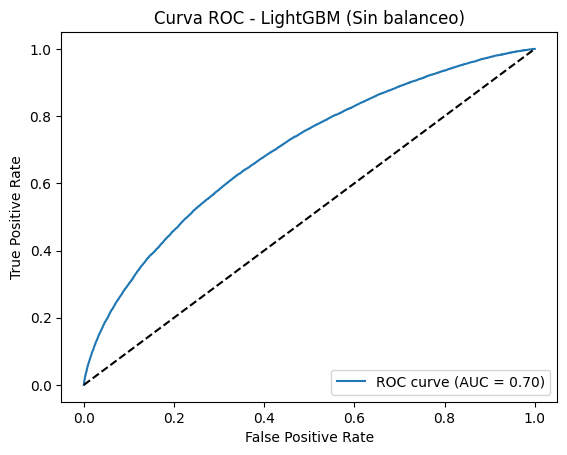


Matriz de confusión:
[[101481    255]
 [ 22771    493]]


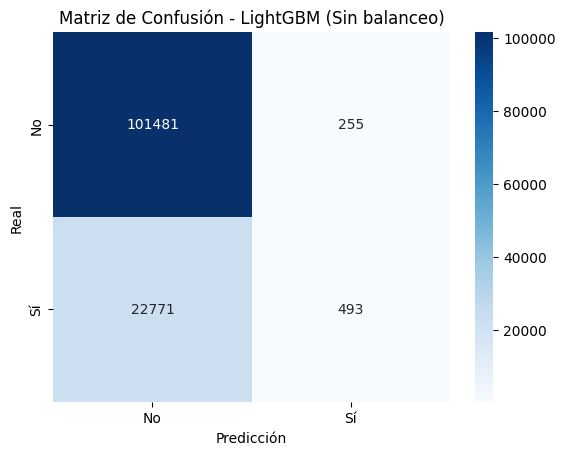


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90    101736
           1       0.66      0.02      0.04     23264

    accuracy                           0.82    125000
   macro avg       0.74      0.51      0.47    125000
weighted avg       0.79      0.82      0.74    125000


Entrenando LightGBM con class_weight
[LightGBM] [Info] Number of positive: 69791, number of negative: 305209
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1691
[LightGBM] [Info] Number of data points in the train set: 375000, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

Evaluación del modelo LightGBM (Class Weight):


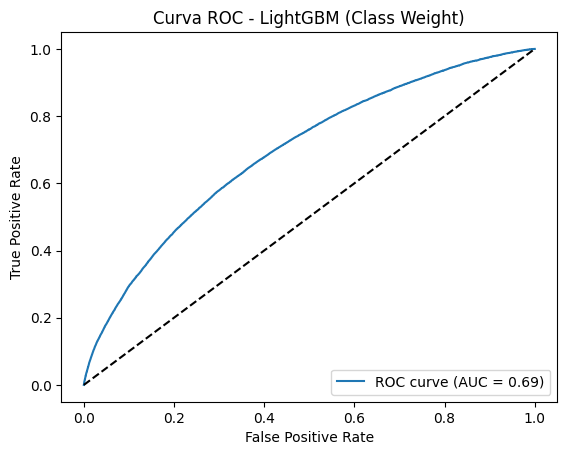


Matriz de confusión:
[[64931 36805]
 [ 8327 14937]]


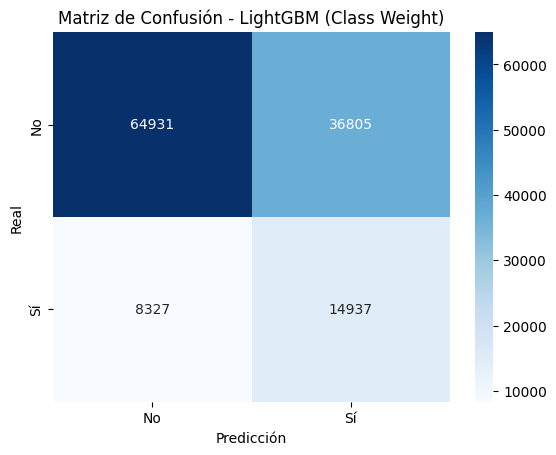


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.89      0.64      0.74    101736
           1       0.29      0.64      0.40     23264

    accuracy                           0.64    125000
   macro avg       0.59      0.64      0.57    125000
weighted avg       0.78      0.64      0.68    125000


Entrenando LightGBM con undersampling
[LightGBM] [Info] Number of positive: 69791, number of negative: 69791
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1693
[LightGBM] [Info] Number of data points in the train set: 139582, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Evaluación del modelo LightGBM (Undersampling):

Accuracy: 0.637
Precision: 0.287
Recall: 0.64
F1 Scor

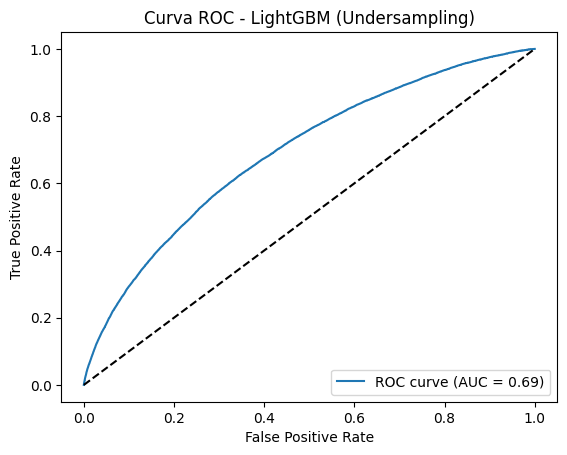


Matriz de confusión:
[[64750 36986]
 [ 8378 14886]]


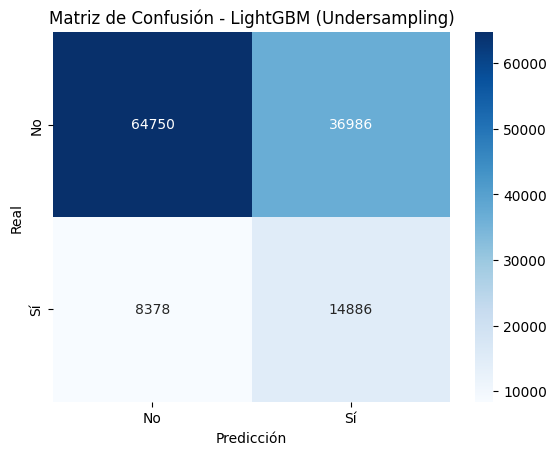


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.89      0.64      0.74    101736
           1       0.29      0.64      0.40     23264

    accuracy                           0.64    125000
   macro avg       0.59      0.64      0.57    125000
weighted avg       0.77      0.64      0.68    125000


Entrenando LightGBM con SMOTE
[LightGBM] [Info] Number of positive: 305209, number of negative: 305209
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.348969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16182
[LightGBM] [Info] Number of data points in the train set: 610418, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Evaluación del modelo LightGBM (SMOTE):

Accuracy: 0.814
Precision: 0.496
Recall: 0.08
F1 Score: 0.137

AUC

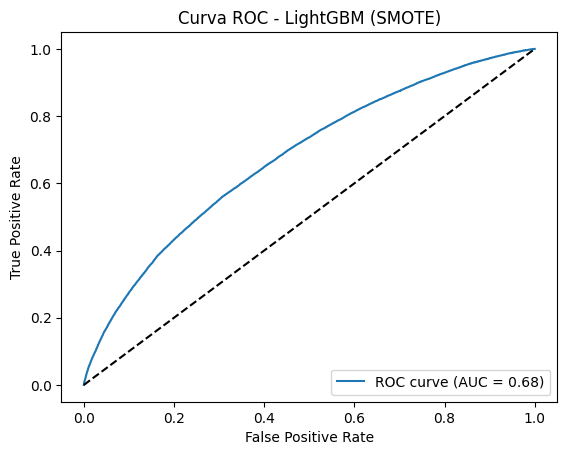


Matriz de confusión:
[[99850  1886]
 [21409  1855]]


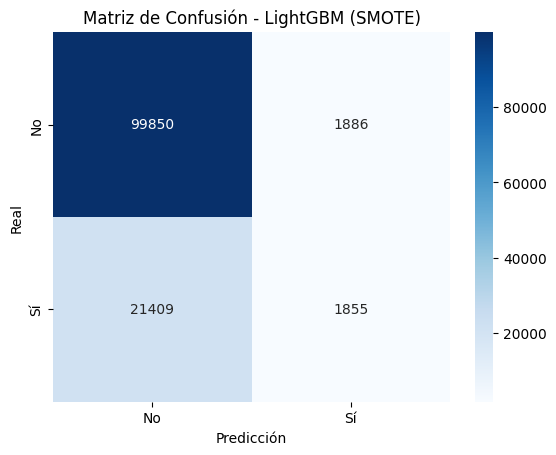


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.82      0.98      0.90    101736
           1       0.50      0.08      0.14     23264

    accuracy                           0.81    125000
   macro avg       0.66      0.53      0.52    125000
weighted avg       0.76      0.81      0.75    125000


MODELO: XGBoost 

Entrenando XGBoost sin balanceo

Evaluación del modelo XGBoost (Sin balanceo):

Accuracy: 0.816
Precision: 0.656
Recall: 0.022
F1 Score: 0.043

AUC-ROC: 0.695


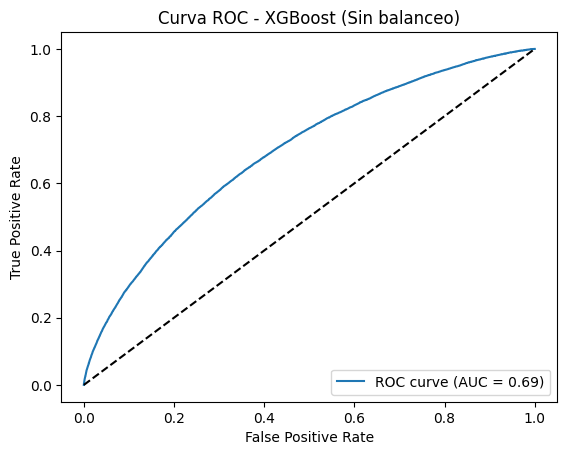


Matriz de confusión:
[[101467    269]
 [ 22750    514]]


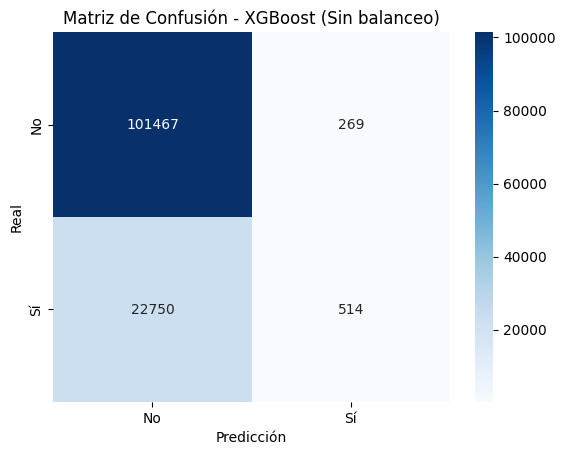


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90    101736
           1       0.66      0.02      0.04     23264

    accuracy                           0.82    125000
   macro avg       0.74      0.51      0.47    125000
weighted avg       0.79      0.82      0.74    125000


Entrenando XGBoost con class_weight

Evaluación del modelo XGBoost (Class Weight):

Accuracy: 0.639
Precision: 0.289
Recall: 0.644
F1 Score: 0.399

AUC-ROC: 0.694


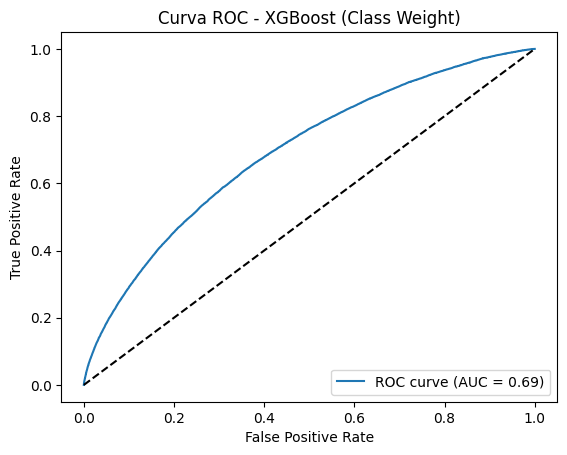


Matriz de confusión:
[[64838 36898]
 [ 8278 14986]]


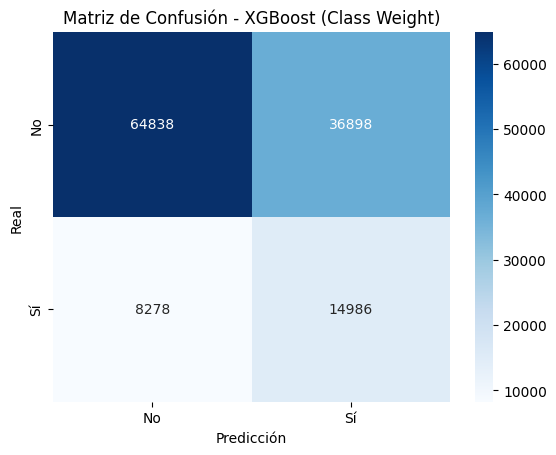


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.89      0.64      0.74    101736
           1       0.29      0.64      0.40     23264

    accuracy                           0.64    125000
   macro avg       0.59      0.64      0.57    125000
weighted avg       0.78      0.64      0.68    125000


Entrenando XGBoost con undersampling

Evaluación del modelo XGBoost (Undersampling):

Accuracy: 0.63
Precision: 0.285
Recall: 0.652
F1 Score: 0.396

AUC-ROC: 0.693


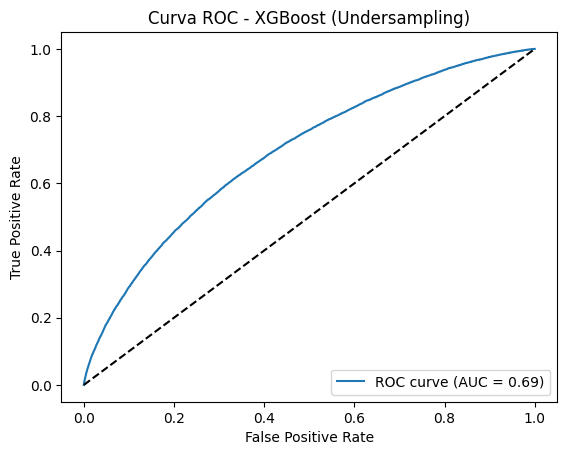


Matriz de confusión:
[[63587 38149]
 [ 8089 15175]]


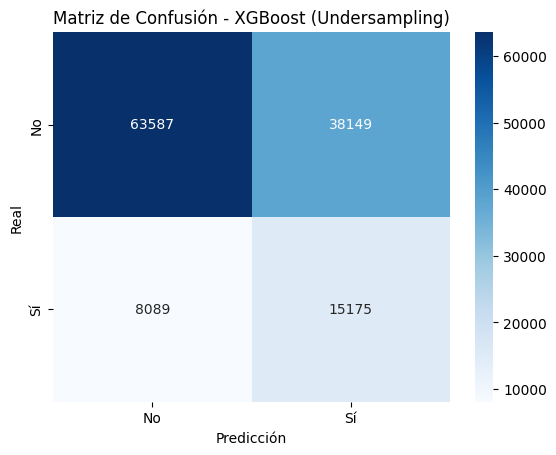


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.89      0.63      0.73    101736
           1       0.28      0.65      0.40     23264

    accuracy                           0.63    125000
   macro avg       0.59      0.64      0.56    125000
weighted avg       0.78      0.63      0.67    125000


Entrenando XGBoost con SMOTE

Evaluación del modelo XGBoost (SMOTE):

Accuracy: 0.803
Precision: 0.403
Recall: 0.121
F1 Score: 0.186

AUC-ROC: 0.659


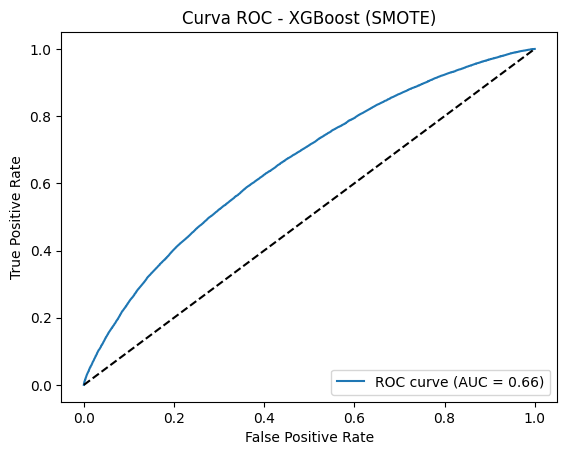


Matriz de confusión:
[[97573  4163]
 [20451  2813]]


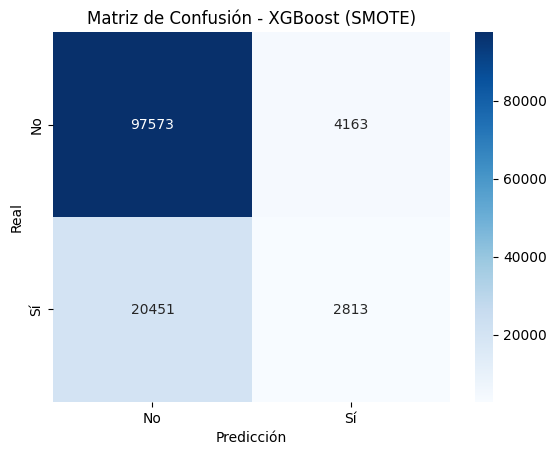


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89    101736
           1       0.40      0.12      0.19     23264

    accuracy                           0.80    125000
   macro avg       0.61      0.54      0.54    125000
weighted avg       0.75      0.80      0.76    125000


MODELO: CatBoost 

Entrenando CatBoost sin balanceo

Evaluación del modelo CatBoost (Sin balanceo):

Accuracy: 0.814
Precision: 0.651
Recall: 0.005
F1 Score: 0.011

AUC-ROC: 0.68


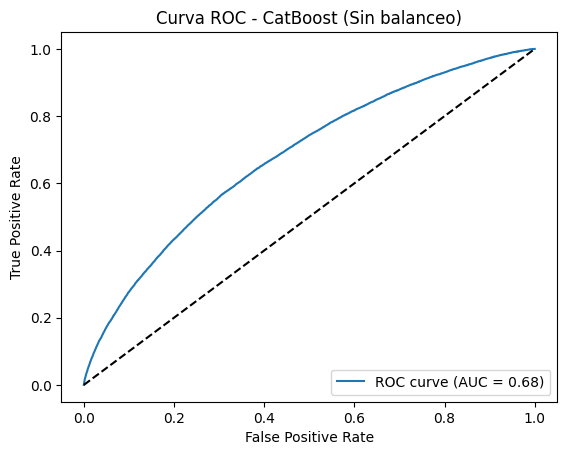


Matriz de confusión:
[[101668     68]
 [ 23137    127]]


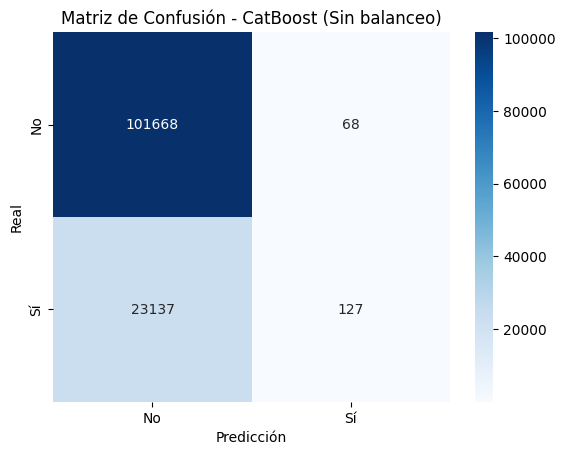


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90    101736
           1       0.65      0.01      0.01     23264

    accuracy                           0.81    125000
   macro avg       0.73      0.50      0.45    125000
weighted avg       0.78      0.81      0.73    125000


Entrenando CatBoost con class_weight

Evaluación del modelo CatBoost (Class Weight):

Accuracy: 0.665
Precision: 0.308
Recall: 0.638
F1 Score: 0.415

AUC-ROC: 0.711


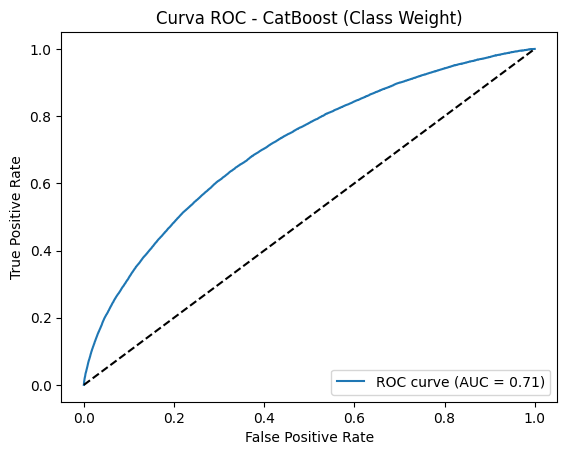


Matriz de confusión:
[[68323 33413]
 [ 8422 14842]]


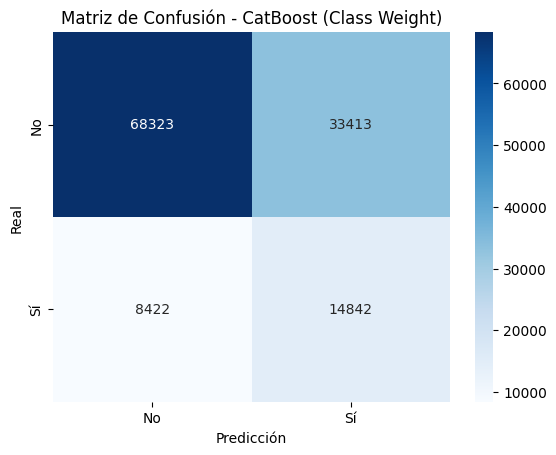


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.89      0.67      0.77    101736
           1       0.31      0.64      0.42     23264

    accuracy                           0.67    125000
   macro avg       0.60      0.65      0.59    125000
weighted avg       0.78      0.67      0.70    125000


Entrenando CatBoost con undersampling

Evaluación del modelo CatBoost (Undersampling):

Accuracy: 0.612
Precision: 0.273
Recall: 0.653
F1 Score: 0.385

AUC-ROC: 0.68


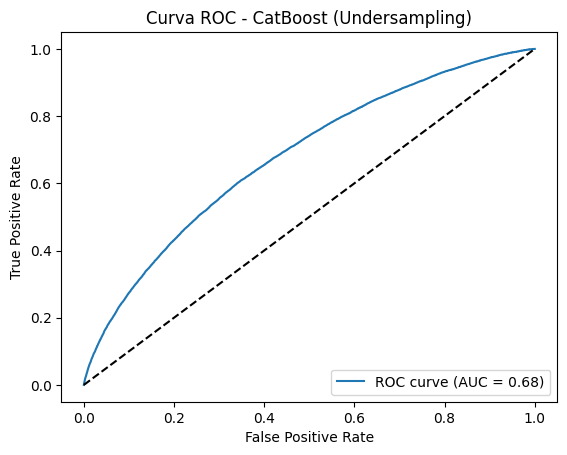


Matriz de confusión:
[[61267 40469]
 [ 8074 15190]]


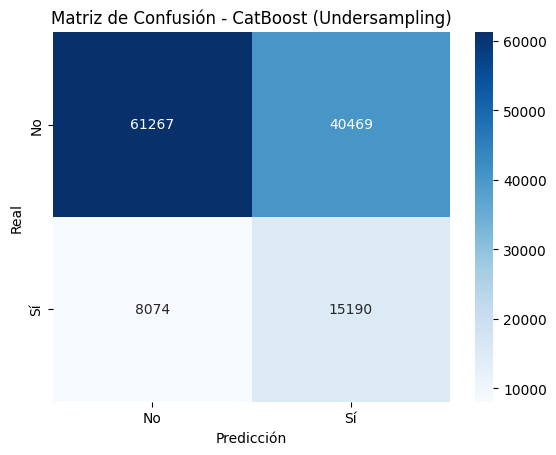


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.60      0.72    101736
           1       0.27      0.65      0.38     23264

    accuracy                           0.61    125000
   macro avg       0.58      0.63      0.55    125000
weighted avg       0.77      0.61      0.65    125000


Entrenando CatBoost con SMOTE

Evaluación del modelo CatBoost (SMOTE):

Accuracy: 0.814
Precision: 0.501
Recall: 0.037
F1 Score: 0.068

AUC-ROC: 0.665


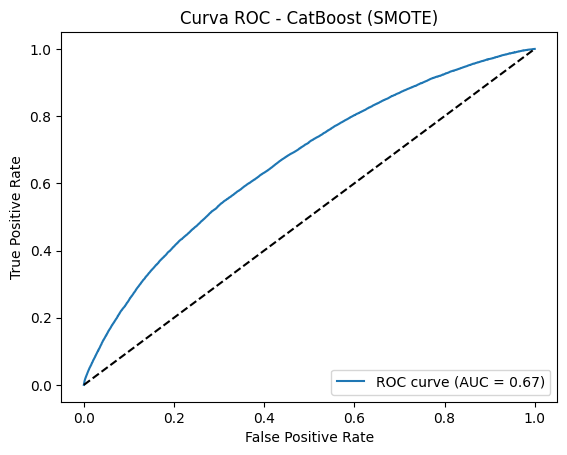


Matriz de confusión:
[[100890    846]
 [ 22413    851]]


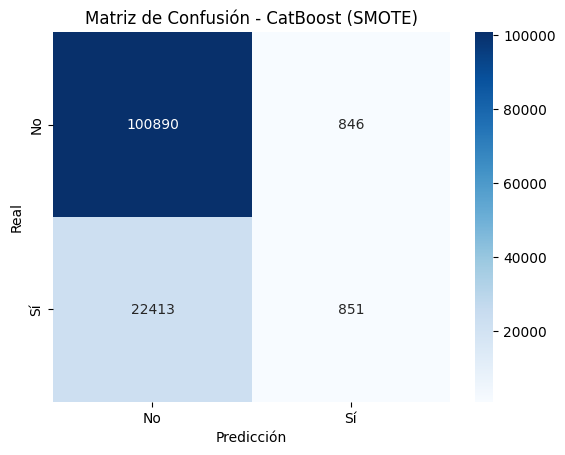


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.82      0.99      0.90    101736
           1       0.50      0.04      0.07     23264

    accuracy                           0.81    125000
   macro avg       0.66      0.51      0.48    125000
weighted avg       0.76      0.81      0.74    125000


Resumen de resultados (ordenados por F1 Score):


,Modelo,Balanceo,F1 Score,Best Params
9,CatBoost,Class Weight,0.415051,Fixed class_weights
5,XGBoost,Class Weight,0.399015,"{'classifier__learning_rate': 0.1, 'classifier..."
1,LightGBM,Class Weight,0.398049,"{'classifier__learning_rate': 0.1, 'classifier..."
2,LightGBM,Undersampling,0.395810,"{'classifier__learning_rate': 0.1, 'classifier..."
6,XGBoost,Undersampling,0.395158,"{'classifier__learning_rate': 0.1, 'classifier..."
10,CatBoost,Undersampling,0.386525,"{'classifier__depth': 6, 'classifier__iteratio..."
7,XGBoost,SMOTE,0.176470,"{'classifier__learning_rate': 0.1, 'classifier..."
3,LightGBM,SMOTE,0.121642,"{'classifier__learning_rate': 0.1, 'classifier..."
11,CatBoost,SMOTE,0.060134,"{'classifier__depth': 6, 'classifier__iteratio..."
4,XGBoost,Sin balanceo,0.040509,"{'classifier__learning_rate': 0.1, 'classifier..."


In [12]:
# Ejecutar todos los modelos y balanceos
df_resultados, modelos_optimizados = run_modelos()

print("\nResumen de resultados (ordenados por F1 Score):")
display(df_resultados.sort_values(by='F1 Score', ascending=False))

#seleccionar el mejor modelo
df_ordenado = df_resultados.sort_values(by='F1 Score', ascending=False)
mejor_modelo_nombre = df_ordenado.iloc[0]['Modelo'] + " (" + df_ordenado.iloc[0]['Balanceo'] + ")"
modelo_final = modelos_optimizados[mejor_modelo_nombre]


In [13]:
#Visualización de importancia para LightGBM y CatBoost (XGBoost también se puede, pero consume más tiempo)
def mostrar_importancia(modelo, nombre_modelo):
    try:
        if nombre_modelo == "CatBoost":
            importancias = modelo.named_steps['classifier'].get_feature_importance()
            nombres = modelo.named_steps['preprocessor'].get_feature_names_out()
        else:
            importancias = modelo.named_steps['classifier'].feature_importances_
            nombres = modelo.named_steps['preprocessor'].get_feature_names_out()

        imp_df = pd.DataFrame({'Feature': nombres, 'Importancia': importancias})
        imp_df = imp_df.sort_values('Importancia', ascending=False).head(15)

        plt.figure(figsize=(10, 6))
        sns.barplot(data=imp_df, x="Importancia", y="Feature")
        plt.title(f"Importancia de Variables - {nombre_modelo}")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"({nombre_modelo} no soporta importancias de variables o error: {e})")

# Mostrar importancia para LightGBM y CatBoost usando el mejor pipeline sin balanceo como ejemplo
for modelo_name in ["LightGBM", "CatBoost"]:
    best_model = None
    for idx, row in df_resultados.iterrows():
        if row['Modelo'] == modelo_name and row['Balanceo'] == 'Sin balanceo':
            best_model = row
            break


In [14]:
#Ejemplo simple
nuevo_vuelo = pd.DataFrame([{
    'MONTH': 7,
    'DAY': 22,
    'DAY_OF_WEEK': 1,
    'DISTANCE': 950,
    'SCHEDULED_DEPARTURE': 830,  # 08:30 am
    'SCHEDULED_ARRIVAL': 1045,   # 10:45 am
    'AIRLINE': 'AA',
    'ORIGIN_AIRPORT': 'JFK',
    'DESTINATION_AIRPORT': 'LAX'
}])

# Función para calcular duración del vuelo en minutos
def calcular_scheduled_time(dep, arr):
    dep = int(str(dep).zfill(4))
    arr = int(str(arr).zfill(4))
    dep_min = (dep // 100) * 60 + (dep % 100)
    arr_min = (arr // 100) * 60 + (arr % 100)
    if arr_min < dep_min:  # vuelos que cruzan medianoche
        arr_min += 1440
    return arr_min - dep_min

nuevo_vuelo['SCHEDULED_TIME'] = calcular_scheduled_time(
    nuevo_vuelo['SCHEDULED_DEPARTURE'].iloc[0],
    nuevo_vuelo['SCHEDULED_ARRIVAL'].iloc[0]
)

# Aplicar transformación trigonométrica para horas
def transformar_hora(df, columna):
    df[columna] = df[columna].astype(str).str.zfill(4)
    minutos = df[columna].str[:2].astype(int) * 60 + df[columna].str[2:].astype(int)
    df[columna + '_sin'] = np.sin(2 * np.pi * minutos / 1440)
    df[columna + '_cos'] = np.cos(2 * np.pi * minutos / 1440)
    return df

nuevo_vuelo = transformar_hora(nuevo_vuelo, 'SCHEDULED_DEPARTURE')
nuevo_vuelo = transformar_hora(nuevo_vuelo, 'SCHEDULED_ARRIVAL')

# Eliminar columnas originales que no usa el modelo
nuevo_vuelo.drop(columns=['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL'], inplace=True)

prediccion = modelo_final.predict(nuevo_vuelo)
probabilidad = modelo_final.predict_proba(nuevo_vuelo)[:, 1]

print(f"\nModelo usado: {mejor_modelo_nombre}")
print(f"¿Vuelo retrasado?: {'Sí' if prediccion[0] == 1 else 'No'}")
print(f"Probabilidad de retraso: {probabilidad[0]:.2f}")


Modelo usado: CatBoost (Class Weight)
¿Vuelo retrasado?: No
Probabilidad de retraso: 0.48
